In [1]:
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from decimal import Decimal
from sklearn import cross_validation
%config InlineBackend.figure_format = 'retina'

/Users/adamcasper/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def simple_GridSearchCV_fit(X_train_val, Y_train_val, n_list, fold):
    """
    A simple grid search function for k with cross-validation in k-NN.
    
    X_train_val: Features for train and val set. 
                 Shape: (num of data points, num of features)
    Y_train_val: Labels for train and val set.
                 Shape: (num of data points,)
    k_list:      The list of k values to try.
    fold:        The number of folds to do the cross-validation.
    
    Return the val and train accuracy matrix of cross-validation. 
    All combinations of k are included in the array. 
    Shape: (len(k_list), )
    """
    val_acc_array = np.zeros(len(n_list))
    train_acc_array = np.zeros(len(n_list))
    for i in range(len(n_list)):
        val_acc_array[i], train_acc_array[i] = simple_cross_validation(X_train_val, Y_train_val, n_list[i], fold)
    return val_acc_array, train_acc_array

In [3]:
def simple_cross_validation(X, Y, n, fold):
    """
    A simple cross-validation function for k-NN.
    
    X_train_val: Features for train and val set. 
                 Shape: (num of data points, num of features)
    Y_train_val: Labels for train and val set.
                 Shape: (num of data points,)
    k:           Parameter k for k-NN.
    fold:        The number of folds to do the cross-validation.
    
    Return the average accuracy on validation set.
    
    """
    
    val_acc_list = []
    train_acc_list = []
    
    topends = 0
    bottomstarts = 0
    val_acc = 0
    train_acc = 0
    for i in range(fold):     
        
        NumPerFold = int(X.shape[0]/fold)
        bottomstarts = NumPerFold*(i+1)
        topends = i * NumPerFold
        Xtrain = np.vstack((X[:topends], X[bottomstarts:]))
        Ytrain = np.vstack((Y[:topends].reshape(-1,1), Y[bottomstarts:].reshape(-1,1))).reshape(-1)
        Xval = X[topends:bottomstarts]
        Yval = Y[topends:bottomstarts]
        numYval = len(Yval)
        
        # Actually you can use the built-in function from sklearn
        # to validate if your implementation is correct or not:
        #    from sklearn.neighbors import KNeighborsClassifier
        #classifier  = KNeighborsClassifier(algorithm='brute', n_neighbors=k)
        classifier = bubble_KNeighborsClassifier(n=n)
        classifier.fit(Xtrain, Ytrain)
        YvalPred = classifier.predict(Xval)
        YtrainPred = classifier.predict(Xtrain)
        
        
        correctval = 0
        for i in range(len(Yval)):
            if Yval[i] == YvalPred[i]:
                correctval = correctval+1       
        val_acc = float(correctval)/len(Yval)
        val_acc_list.append(val_acc)
        
        correcttrain = 0
        for i in range(len(Ytrain)):
            if Ytrain[i] == YtrainPred[i] :
                correcttrain = correcttrain+1
        train_acc = float(correcttrain)/len(Ytrain)
        train_acc_list.append(train_acc)
        
    return sum(val_acc_list) / len(val_acc_list), \
           sum(train_acc_list) / len(train_acc_list)

In [4]:
def getNpercentSamples(X, percent):
    n = int(len(X)*percent)
    return n

In [5]:

def splitSets(X_and_Y, n):
    np.random.shuffle(X_and_Y)
    X = X_and_Y[:, :-1]       # First column to second last column: Features (numerical values) 
    Y = X_and_Y[:, -1:]       # Last column: Labels (0 or 1)
    X_train_val = X[:n, :] # Get features from train + val set.
    X_test      = X[n:, :] # Get features from test set.     
    Y_train_val = Y[:n, :].reshape(-1) # Get labels from train + val set.
    Y_test      = Y[n:, :].reshape(-1) # Get labels from test set.  
    
    return X_train_val, X_test, Y_train_val, Y_test
    
#print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

In [6]:
def treeClassifier(X_train_val, Y_train_val):
    classifier = DecisionTreeClassifier(criterion="entropy")
    D_list     = [1, 2, 3, 4, 5] # Different D to try.
    param = {'max_depth': D_list}
    clf = GridSearchCV(classifier, param, cv=5)
    return clf.fit(X_train_val, Y_train_val)

In [7]:
def knnClassifier(X_train_val, Y_train_val): 
    classifier = KNeighborsClassifier(algorithm='brute') 
    K = [1, 2, 3, 4, 5] 
    params = {'n_neighbors': K}

    clf = GridSearchCV(classifier, params, cv=5)
    return clf.fit(X_train_val, Y_train_val)

In [8]:
def bubble_knnClassifier(X_train_val, Y_train_val):
    classifier = bubble_KNeighborsClassifier()
    nsamples = [5, 6, 7, 8, 9, 10]
    n = [3,4,5,6,7]
    multiplier = [0.125 ,0.25, 0.5, 0.75, 1, 1.5, 1.75, 2]
    param = {'nsamples': nsamples, 'n': n, 'multiplier': multiplier}
    
    clf = simple_GridSearchCV_fit(X_train_val, Y_train_val, n, fold=5)
    return clf

In [9]:
def draw_heatmap_knn(acc, acc_desc, n_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=n_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$n$')
    plt.title(acc_desc + ' w.r.t $n$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    

In [10]:
def simple_knnClassifier(X_train_val, Y_train_val):
   
    classifier = simple_KNeighborsClassifier(k=3)
    K = [1, 2, 3, 4, 5]
    param = {'k': K}
    
    clf = GridSearchCV(classifier, param, cv=5, scoring='accuracy' )
    return clf.fit(X_train_val, Y_train_val)

In [11]:
def draw_heatmap_knn(acc, acc_desc, k_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=k_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$n$')
    plt.title(acc_desc + ' w.r.t $n$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

In [12]:
def svmClassifier(X_train_val, Y_train_val):
    classifier = svm.SVC()
    gamma_list = [1e-7, 1e-6, 1e-5, 1e-4]
    C_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0] # Different C to try.
    param = {'kernel':['linear','rbf'], 'C': C_list, 'gamma': gamma_list}
    clf = GridSearchCV(classifier, param, cv=5)
    return clf.fit(X_train_val, Y_train_val)

In [13]:
carX_and_Y = pd.read_table('auto-mpg.txt', header=None, delim_whitespace=True)      # Load data from file.
carX_and_Y.rename(columns={8: 'car'}, inplace=True)
carX_and_Y['origin'] = None
carX_and_Y = carX_and_Y[[0, 1, 2, 3, 4, 5, 6, 7, 'car', 'origin']]
carX_and_Y = carX_and_Y[carX_and_Y[3] != '?']

for i, row in carX_and_Y.iterrows():
    car_val = 0
    if row['car'].startswith("chevrolet") or row['car'].startswith("buick") or row['car'].startswith("plymouth") or row['car'].startswith("amc") or row['car'].startswith("ford") or row['car'].startswith("pontiac") or row['car'].startswith("dodge") or row['car'].startswith("chevy") or row['car'].startswith("mercury") or row['car'].startswith("chrysler") or row['car'].startswith("oldsmobile") or row['car'].startswith("cadillac"):
        car_val = 1
        carX_and_Y.set_value(i,'origin', car_val)
    else:
        carX_and_Y.set_value(i, 'origin', car_val)
    
        
carX_and_Y.drop(['car'], axis=1, inplace=True)
carX_and_Y = carX_and_Y.astype('float64')

        
carX_and_Y = carX_and_Y.as_matrix()
np.random.seed(0)
np.random.shuffle(carX_and_Y)   # Shuffle the data.
#X = carX_and_Y[:, :-1]       # First column to second last column: Features (numerical values) 
#Y = carX_and_Y[:, -1:]       # Last column: Labels (0 or 1)

In [14]:


car = carX_and_Y
#cover = coverX_and_Y[:300]
#letter = letterX_and_Y[:150]
#X_train_val, X_test, Y_train_val, Y_test = splitSets(car, splitIndex)
#print(np.unique(Y_train_val))
#print(np.unique(Y_test))

NameError: name 'coverX_and_Y' is not defined

In [15]:
class bubble_KNeighborsClassifier(object):
    def __init__(self, n=5, nsamples=10, multiplier=0.5):
        """
        k-NN initialization.
            k: Number of nearest neighbors.
        """
        
        self.n = n
        self.nsamples = nsamples
        self.multiplier = multiplier
        
    def fit(self, X_train, Y_train):
        """
        k-NN fitting function.
            X_train: Feature vectors in training set.
            Y_train: Labels in training set.
        """
        self.X_train = X_train
        self.Y_train = Y_train
        
    def predict(self, X_pred):
        """
        k-NN prediction function.
        X_pred: Feature vectors in training set.
        Return the predicted labels for X_pred. Shape: (len(X_pred), ).
        
        """
        """Randomly choose n samples of the same class and calculate the average
           distance between them to determine the size of the bubble around a 
           sample to predict
           
        """
        increment=0
        sumdist = 0
        avgDist = 0
        nPoints = []
        
        zero = np.zeros((1,1))
        for i in range(len(self.Y_train)):
            if self.Y_train[i] == zero:
                nPoints.append(self.X_train[i])
                increment+=1
            if increment == self.nsamples:
                break
        for sampl in nPoints:
            for point in nPoints:
                #if np.array_equal(point,sampl)==False:
                distance = np.linalg.norm(np.array(point) - np.array(sampl))
                    #print(distance)
                sumdist += distance
        avgDist = sumdist / (len(nPoints)*len(nPoints))
        
        
                
            
        Y_pred = []
        
        
        maximum = 100
        iterations = 0
        
        
        for sample in X_pred:
            count = 0
            bubbleGroupindex = []
            
            for index, instance in enumerate(self.X_train, start=0):    
                if np.array_equal(instance,sample)==False:
                    features = 0
                    for i in range(len(instance)):
                        
                        if np.greater(instance[i],(sample[i]-self.multiplier*avgDist)) and np.less(instance[i],(sample[i]+self.multiplier*avgDist)):
                            features+=1
                        else:
                            break
                        if features == len(instance):
                            bubbleGroupindex.append(index)
                        
                            
                            count+=1
                        if count==self.n:
                            break
                    iterations+=1
                if count==self.n or iterations == maximum:
                    break
            bubbleindices = np.asarray(bubbleGroupindex)
            #print(bubbleindices)
            """"print(bubble)    
            dist = 0   
            dList = []
            
            for index in bubble:
                #if np.array_equal(datapoint,sample)==False:
                distances = np.linalg.norm(np.array(self.X_train[index]) - np.array(sample))
                distances_and_labels = [(distances[i], self.Y_train[i]) \
                                    for i in range(len(self.X_train))]
            print(distances_and_lables)
            
            
            
            #get k closest neighbors indices
            Neighborsindices = Dlist.argsort()[:self.k]"""
            
            label0 = 0
            label1 = 0
            pred = 0
            
            for index in bubbleindices:
                if self.Y_train[index]==0:
                    label0 +=1
                else:
                    label1 +=1
            if label1 >= label0:
                pred = 1
            else:
                pred = 0
                
            Y_pred.append(pred)
        return np.array(Y_pred)
                
                
       

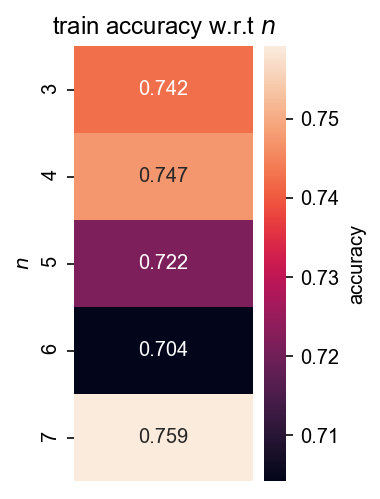

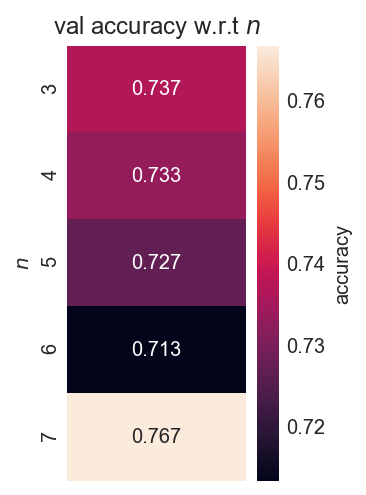

In [16]:

X_train_val, X_test, Y_train_val, Y_test = splitSets(carX_and_Y, 300)
n = [3,4,5,6,7]
val_acc_array, train_acc_array = bubble_knnClassifier(X_train_val, Y_train_val)
draw_heatmap_knn(train_acc_array.reshape(-1,1), 'train accuracy', n)
draw_heatmap_knn(val_acc_array.reshape(-1,1), 'val accuracy', n)


In [17]:
# 3) Implement the k-NN.
class simple_KNeighborsClassifier(object):
    def __init__(self, k=5):

        
 
        """
        k-NN initialization.
            k: Number of nearest neighbors.
        """
        self.k = k
        
    def fit(self, X_train, Y_train):
        """
        k-NN fitting function.
            X_train: Feature vectors in training set.
            Y_train: Labels in training set.
        """
        self.X_train = X_train
        self.Y_train = Y_train
        
    def predict(self, X_pred):
        """
        k-NN prediction function.
            X_pred: Feature vectors in training set.
        Return the predicted labels for X_pred. Shape: (len(X_pred), )
        """
        Y_pred = []
        for i in range(len(X_pred)):
            distances = ((self.X_train - X_pred[i].reshape(1,-1)) \
                          ** 2.0).sum(axis = 1)
            distances_and_labels = [(distances[i], self.Y_train[i]) \
                                    for i in range(len(self.X_train))]
            distances_and_labels.sort()
            top_k_labels = np.array(distances_and_labels)[:self.k,1].ravel()
            mode, _ = scipy.stats.mode(top_k_labels)
            Y_pred.append(mode[0])
        return np.array(Y_pred)
   
        
        
        

In [18]:
def bubbleACC(X_train_val, Y_train_val, X_test, Y_test,n):

    

    test_acc_list = []

    nsampl = 10
    multipl = .25


    classifier = bubble_KNeighborsClassifier(n=n,nsamples=nsampl,multiplier=multipl)
    classifier.fit(X_train_val, Y_train_val)
    YtestPred = classifier.predict(X_test)
    YtrainPred = classifier.predict(X_train_val)


    traincorrectval = 0
    for i in range(len(Y_train_val)):
        if YtrainPred[i] == Y_train_val[i]:
            traincorrectval +=1
        
    testcorrectval = 0
    for i in range(len(Y_test)):
        if YtestPred[i] == Y_test[i]:
            testcorrectval +=1



    testacc = float(testcorrectval) / len(Y_test)

    trainacc = float(traincorrectval) / len(Y_train_val)


    return trainacc, testacc


In [19]:
#%%timeit
np.random.shuffle(carX_and_Y)
X_train_val, X_test, Y_train_val, Y_test = splitSets(carX_and_Y,300)

test_acc_list = []


#k=3
n=3
nsamples = 10
multiplier = .25


classifier = simple_KNeighborsClassifier(k=n)
classifier.fit(X_train_val, Y_train_val)
YtestPred = classifier.predict(X_test)
#YtrainPred = classifier.predict()


correctval = 0
for i in range(len(Y_test)):
    if YtestPred[i] == Y_test[i]:
        correctval +=1

#print(correctval)
#print(len(Y_test))

accuracy = float(correctval) / len(Y_test)
print(accuracy)

0.760869565217


In [20]:
#1. load and clean carX_and_Y
#   load and clean letterX_and_Y
#   load and clean coverX_and_Y
trainResults = np.zeros((36,4))
testResults = np.zeros((36,4))

SPLITS = np.array([0.2,0.5,0.8])
DATASETS = [car]

scorerow = 0
avgrow = 27
for splitindex, split in enumerate(SPLITS, start=0):
    for datasetindex, dataset in enumerate(DATASETS, start=0):
        splitIndex = getNpercentSamples(dataset, split)
        

        treeAccSumtest = 0
        knnAccSumtest = 0
        svmAccSumtest = 0
        treeAccSumtrain = 0
        knnAccSumtrain = 0
        svmAccSumtrain = 0
        bubbleAccSumtest = 0
        bubbleAccSumtrain = 0
        X_train_val, X_test, Y_train_val, Y_test = splitSets(dataset, splitIndex)
        for i in range(3):
            
            '''#Decision Tree
            treeCLF = treeClassifier(X_train_val, Y_train_val)
            bestTree = DecisionTreeClassifier(criterion="entropy", max_depth=(treeCLF.best_params_['max_depth'])).fit(X_train_val, Y_train_val)
            treeAccSumtest +=  bestTree.score(X_test, Y_test)
            treeAccSumtrain += bestTree.score(X_train_val, Y_train_val) 
            testResults[scorerow,0] = bestTree.score(X_test, Y_test)
            trainResults[scorerow,0] = bestTree.score(X_train_val, Y_train_val)
        
            
            
            #k_NN
            knnCLF = knnClassifier(X_train_val, Y_train_val)
            bestKNN = KNeighborsClassifier(n_neighbors = knnCLF.best_params_["n_neighbors"]).fit(X_train_val, Y_train_val)
            knnAccSumtest += bestKNN.score(X_test, Y_test)
            knnAccSumtrain += bestKNN.score(X_train_val, Y_train_val) 
            testResults[scorerow,1] = bestKNN.score(X_test, Y_test)
            trainResults[scorerow,1] = bestKNN.score(X_train_val, Y_train_val)
           

            #SVM
            svmCLF = svmClassifier(X_train_val, Y_train_val)
            bestSVM = svm.SVC(kernel = (svmCLF.best_params_["kernel"]), C =(svmCLF.best_params_["C"])).fit(X_train_val, Y_train_val) 
            svmAccSumtest += bestSVM.score(X_test, Y_test)
            svmAccSumtrain += bestSVM.score(X_train_val, Y_train_val) 
            testResults[scorerow,2] = bestSVM.score(X_test, Y_test)
            trainResults[scorerow,2] = bestSVM.score(X_train_val, Y_train_val)'''
            
            #bubble_KNN
            trainACC, testACC = bubbleACC(X_train_val, Y_train_val, X_test, Y_test,n=5)
            bubbleAccSumtest += testACC
            bubbleAccSumtrain += trainACC
            testResults[scorerow,3] = testACC
            trainResults[scorerow,3] = trainACC
            
            
            

            
            scorerow +=1
            print(scorerow)
        
        
        '''testResults[avgrow,0] = treeAccSumtest / 3.0
        trainResults[avgrow,0] = treeAccSumtrain / 3.0
        
        testResults[avgrow,1] = knnAccSumtest / 3.0
        trainResults[avgrow,1] = knnAccSumtrain / 3.0
        
        testResults[avgrow,2] = svmAccSumtest / 3.0
        trainResults[avgrow,2] = svmAccSumtrain / 3.0'''
        
        testResults[avgrow,3] = bubbleAccSumtest / 3.0
        trainResults[avgrow,3] = bubbleAccSumtrain / 3.0
        
        
        
        avgrow +=1
            
            
            
       

1
2
3
4
5
6
7
8
9


In [21]:
testResults

array([[ 0.        ,  0.        ,  0.        ,  0.71656051],
       [ 0.        ,  0.        ,  0.        ,  0.71656051],
       [ 0.        ,  0.        ,  0.        ,  0.71656051],
       [ 0.        ,  0.        ,  0.        ,  0.76530612],
       [ 0.        ,  0.        ,  0.        ,  0.76530612],
       [ 0.        ,  0.        ,  0.        ,  0.76530612],
       [ 0.        ,  0.        ,  0.        ,  0.72151899],
       [ 0.        ,  0.        ,  0.        ,  0.72151899],
       [ 0.        ,  0.        ,  0.        ,  0.72151899],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.

In [22]:
trainResults

array([[ 0.        ,  0.        ,  0.        ,  0.73076923],
       [ 0.        ,  0.        ,  0.        ,  0.73076923],
       [ 0.        ,  0.        ,  0.        ,  0.73076923],
       [ 0.        ,  0.        ,  0.        ,  0.71938776],
       [ 0.        ,  0.        ,  0.        ,  0.71938776],
       [ 0.        ,  0.        ,  0.        ,  0.71938776],
       [ 0.        ,  0.        ,  0.        ,  0.7284345 ],
       [ 0.        ,  0.        ,  0.        ,  0.7284345 ],
       [ 0.        ,  0.        ,  0.        ,  0.7284345 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.